In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import joblib

# ====== 1. データの読み込みと前処理 ======
df = pd.read_csv("hand_landmarks.csv")

# 特徴量とラベルに分ける
X = df.drop('label', axis=1).values
y = df['label'].values

# ラベルエンコーディング
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# ワンホットエンコーディング
y_onehot = tf.keras.utils.to_categorical(y_encoded)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=40)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# ====== 2. モデル構築 ======
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # クラス数に応じて調整
])

# ====== 3. モデルコンパイル ======
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ====== 4. モデル訓練 ======
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=0)

# 途中経過を出力（例：100エポックごと）
for epoch in range(0, 1000, 100):
    acc = history.history['accuracy'][epoch]
    print(f"Epoch {epoch}, Accuracy: {acc:.4f}")

# ====== 5. テスト精度の評価 ======
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"モデルの正解率: {acc:.2f}")

# ====== 6. モデル保存 ======
model.save('hand_gesture_model_tf.h5')
joblib.dump(label_encoder, 'label_encoder.pkl')
print("モデルとエンコーダを保存しました。")


X_train shape: (1635, 63)
X_test shape: (409, 63)
Epoch 0, Accuracy: 0.3810
Epoch 100, Accuracy: 0.9456
Epoch 200, Accuracy: 0.9511
Epoch 300, Accuracy: 0.9541
Epoch 400, Accuracy: 0.9566
Epoch 500, Accuracy: 0.9621
Epoch 600, Accuracy: 0.9517
Epoch 700, Accuracy: 0.9492
Epoch 800, Accuracy: 0.9560
Epoch 900, Accuracy: 0.9621
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


モデルの正解率: 0.98
モデルとエンコーダを保存しました。


In [ ]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import sys

# ====== 画像の前処理 ======
def load_images_from_folder(folder_path, img_size=(64, 64)):
    X = []
    y = []

    for label in ['0', '1', '2']:  # グー・チョキ・パーを想定
        class_dir = os.path.join(folder_path, label)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGBに変換（任意）
                X.append(img / 255.0)  # 正規化
                y.append(int(label))

    return np.array(X), np.array(y)

# ====== モデル構築 ======
def build_cnn_model(input_shape, num_classes=3):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ====== 実行部分 ======
if __name__ == "__main__":
    image_dir = '../create_dataset/images'
    X, y = load_images_from_folder(image_dir, img_size=(64, 64))

    y_cat = to_categorical(y, num_classes=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

    model = build_cnn_model(input_shape=X_train.shape[1:], num_classes=3)

    # Early stopping (optional)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history_cnn = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    # テスト評価
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'CNNモデルのテスト精度: {test_acc:.4f}')

    # モデル保存（HDF5形式）
    model.save('cnn_hand_gesture_model.keras')
    print('CNNモデルを保存しました。')


C:\Users\2321004\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.3736 - loss: 1.1127 - val_accuracy: 0.3906 - val_loss: 1.0915
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3867 - loss: 1.0878 - val_accuracy: 0.2969 - val_loss: 1.1135
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.3704 - loss: 1.0766 - val_accuracy: 0.3906 - val_loss: 1.0904
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.3640 - loss: 1.0809 - val_accuracy: 0.3750 - val_loss: 1.0914
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.3942 - loss: 1.0834 - val_accuracy: 0.4688 - val_loss: 1.0824
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.4472 - loss: 1.0589 - val_accuracy: 0.4844 - val_loss: 1.0614
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.4979 - loss: 1.0322 - val_accuracy: 0.4844 - val_loss: 1.0368
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.4879 - loss: 1.0007 - val_accuracy: 0.4688 - val_loss:

KeyError: 'val_accuracy'

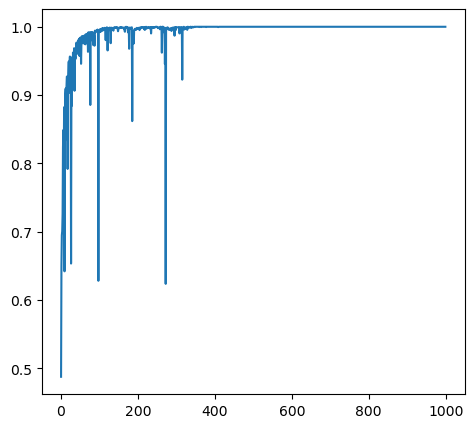

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 精度の比較
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='MLP train acc')
plt.plot(history['val_accuracy'], label='MLP val acc')
plt.plot(cnn_history['accuracy'], label='CNN train acc')
plt.plot(cnn_history['val_accuracy'], label='CNN val acc')
plt.title('モデルの精度比較')
plt.xlabel('エポック')
plt.ylabel('精度')
plt.legend()

# 損失の比較
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='MLP train loss')
plt.plot(history['val_loss'], label='MLP val loss')
plt.plot(cnn_history['loss'], label='CNN train loss')
plt.plot(cnn_history['val_loss'], label='CNN val loss')
plt.title('モデルの損失比較')
plt.xlabel('エポック')
plt.ylabel('損失')
plt.legend()

plt.tight_layout()
plt.show()
